In [1]:
import argparse
import os
import random
import shutil
import time
import warnings
import math
import numpy as np
from PIL import ImageOps, Image
import tempfile

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn.functional as F

from torchvision.utils import save_image

import matplotlib.pyplot as plt

from tqdm import tqdm
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
imagenet_r_wnids = ['n01443537', 'n01484850', 'n01494475', 'n01498041', 'n01514859', 'n01518878', 'n01531178', 'n01534433', 'n01614925', 'n01616318', 'n01630670', 'n01632777', 'n01644373', 'n01677366', 'n01694178', 'n01748264', 'n01770393', 'n01774750', 'n01784675', 'n01806143', 'n01820546', 'n01833805', 'n01843383', 'n01847000', 'n01855672', 'n01860187', 'n01882714', 'n01910747', 'n01944390', 'n01983481', 'n01986214', 'n02007558', 'n02009912', 'n02051845', 'n02056570', 'n02066245', 'n02071294', 'n02077923', 'n02085620', 'n02086240', 'n02088094', 'n02088238', 'n02088364', 'n02088466', 'n02091032', 'n02091134', 'n02092339', 'n02094433', 'n02096585', 'n02097298', 'n02098286', 'n02099601', 'n02099712', 'n02102318', 'n02106030', 'n02106166', 'n02106550', 'n02106662', 'n02108089', 'n02108915', 'n02109525', 'n02110185', 'n02110341', 'n02110958', 'n02112018', 'n02112137', 'n02113023', 'n02113624', 'n02113799', 'n02114367', 'n02117135', 'n02119022', 'n02123045', 'n02128385', 'n02128757', 'n02129165', 'n02129604', 'n02130308', 'n02134084', 'n02138441', 'n02165456', 'n02190166', 'n02206856', 'n02219486', 'n02226429', 'n02233338', 'n02236044', 'n02268443', 'n02279972', 'n02317335', 'n02325366', 'n02346627', 'n02356798', 'n02363005', 'n02364673', 'n02391049', 'n02395406', 'n02398521', 'n02410509', 'n02423022', 'n02437616', 'n02445715', 'n02447366', 'n02480495', 'n02480855', 'n02481823', 'n02483362', 'n02486410', 'n02510455', 'n02526121', 'n02607072', 'n02655020', 'n02672831', 'n02701002', 'n02749479', 'n02769748', 'n02793495', 'n02797295', 'n02802426', 'n02808440', 'n02814860', 'n02823750', 'n02841315', 'n02843684', 'n02883205', 'n02906734', 'n02909870', 'n02939185', 'n02948072', 'n02950826', 'n02951358', 'n02966193', 'n02980441', 'n02992529', 'n03124170', 'n03272010', 'n03345487', 'n03372029', 'n03424325', 'n03452741', 'n03467068', 'n03481172', 'n03494278', 'n03495258', 'n03498962', 'n03594945', 'n03602883', 'n03630383', 'n03649909', 'n03676483', 'n03710193', 'n03773504', 'n03775071', 'n03888257', 'n03930630', 'n03947888', 'n04086273', 'n04118538', 'n04133789', 'n04141076', 'n04146614', 'n04147183', 'n04192698', 'n04254680', 'n04266014', 'n04275548', 'n04310018', 'n04325704', 'n04347754', 'n04389033', 'n04409515', 'n04465501', 'n04487394', 'n04522168', 'n04536866', 'n04552348', 'n04591713', 'n07614500', 'n07693725', 'n07695742', 'n07697313', 'n07697537', 'n07714571', 'n07714990', 'n07718472', 'n07720875', 'n07734744', 'n07742313', 'n07745940', 'n07749582', 'n07753275', 'n07753592', 'n07768694', 'n07873807', 'n07880968', 'n07920052', 'n09472597', 'n09835506', 'n10565667', 'n12267677']
imagenet_r_wnids.sort()
classes_chosen = imagenet_r_wnids[::2] # Choose 100 classes for our dataset
assert len(classes_chosen) == 100

def make_block(hidden_planes=64):
    return nn.Sequential(
        nn.Conv2d(3, hidden_planes, kernel_size=5, stride=1, padding=2),
        # nn.BatchNorm2d(hidden_planes),
        nn.ReLU(),
        nn.Conv2d(hidden_planes, hidden_planes, kernel_size=5, stride=1, padding=2, groups=8),
        # nn.BatchNorm2d(hidden_planes),
        nn.ReLU(),
        nn.Conv2d(hidden_planes, hidden_planes, kernel_size=5, stride=1, padding=2, groups=8),
        # nn.BatchNorm2d(hidden_planes),
        nn.ReLU(),
        nn.Conv2d(hidden_planes, 3, kernel_size=3, stride=1, padding=1)
    )

class BlockWrapper(torch.nn.Module):
    def __init__(self, hidden_planes=64, advnet_norm_factor=0.2):
        super(BlockWrapper, self).__init__()

        self.block1 = make_block(hidden_planes=hidden_planes)
        self.block2 = make_block(hidden_planes=hidden_planes)
        self.advnet_norm_factor = advnet_norm_factor
    
    def forward(self, x):

        batch_size = x.shape[0]
        select = torch.tensor([random.random() < 1.0 for _ in range(batch_size)])
        x_advnet = x[select]

        block_out = self.block1(x_advnet)
        factor = (torch.norm(x_advnet) / torch.norm(block_out))
        x_advnet = block_out * factor * self.advnet_norm_factor + x_advnet

        block_out = self.block2(x_advnet)
        factor = (torch.norm(x_advnet) / torch.norm(block_out))
        x_advnet = block_out * factor * self.advnet_norm_factor + x_advnet

        x[select] = x_advnet

        return x


class ParallelResNet(torch.nn.Module):
    def __init__(self, epsilon=0.2, hidden_planes=64, advnet_norm_factor=0.2, num_parallel=len(classes_chosen)):
        super(ParallelResNet, self).__init__()
        
        self.epsilon = epsilon
        self.hidden_planes = hidden_planes
        self.advnet_norm_factor = advnet_norm_factor
        
        self.blocks = torch.nn.ModuleList(
            [
                torch.nn.DataParallel(
                    BlockWrapper(hidden_planes=hidden_planes, advnet_norm_factor=advnet_norm_factor)
                ) 
                for i in range(num_parallel)
            ]
        )
    
    def forward(self, x, road):
        
        # Assume we put this on GPU before and remove it after.
        block_chosen = self.blocks[road]
        x = block_chosen(x)

        return {"output" : x}


In [3]:
# Useful for undoing thetorchvision.transforms.Normalize() 
# From https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        # The normalize code -> t.sub_(m).div_(s)
        if len(tensor.shape) == 3:
            assert tensor.shape[0] == 3
            for t, m, s in zip(tensor, self.mean, self.std):
                t.mul_(s).add_(m)
            return tensor
        elif len(tensor.shape) == 4:
            assert tensor.shape[1] == 3
            for image in tensor:
                for t, m, s in zip(image, self.mean, self.std):
                    t.mul_(s).add_(m)
            return tensor        
        else:
            raise NotImplementedError("huh??")


unnorm_fn = UnNormalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])

class ImageNetSubsetDataset(datasets.ImageFolder):
    """
    Dataset class to take a specified subset of some larger dataset
    """
    def __init__(self, root, *args, **kwargs):
        
        print("Using {0} classes {1}".format(len(classes_chosen), classes_chosen))

        self.new_root = tempfile.mkdtemp()
        for _class in classes_chosen:
            orig_dir = os.path.join(root, _class)
            assert os.path.isdir(orig_dir)

            os.symlink(orig_dir, os.path.join(self.new_root, _class))
        
        super().__init__(self.new_root, *args, **kwargs)
    
    def __del__(self):
        # Clean up
        shutil.rmtree(self.new_root)

        
val_dataset = ImageNetSubsetDataset(
    "/var/tmp/namespace/hendrycks/imagenet/val",
    transform=transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=64, 
    shuffle=True,
    num_workers=4, 
    pin_memory=True, 
)

Using 100 classes ['n01443537', 'n01494475', 'n01514859', 'n01531178', 'n01614925', 'n01630670', 'n01644373', 'n01694178', 'n01770393', 'n01784675', 'n01820546', 'n01843383', 'n01855672', 'n01882714', 'n01944390', 'n01986214', 'n02009912', 'n02056570', 'n02071294', 'n02085620', 'n02088094', 'n02088364', 'n02091032', 'n02092339', 'n02096585', 'n02098286', 'n02099712', 'n02106030', 'n02106550', 'n02108089', 'n02109525', 'n02110341', 'n02112018', 'n02113023', 'n02113799', 'n02117135', 'n02123045', 'n02128757', 'n02129604', 'n02134084', 'n02165456', 'n02206856', 'n02226429', 'n02236044', 'n02279972', 'n02325366', 'n02356798', 'n02364673', 'n02395406', 'n02410509', 'n02437616', 'n02447366', 'n02480855', 'n02483362', 'n02510455', 'n02607072', 'n02672831', 'n02749479', 'n02793495', 'n02802426', 'n02814860', 'n02841315', 'n02883205', 'n02909870', 'n02948072', 'n02951358', 'n02980441', 'n03124170', 'n03345487', 'n03424325', 'n03467068', 'n03494278', 'n03498962', 'n03602883', 'n03649909', 'n0371

Loaded advnet


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


n04536866
(224, 224, 3)
(224, 224, 3)


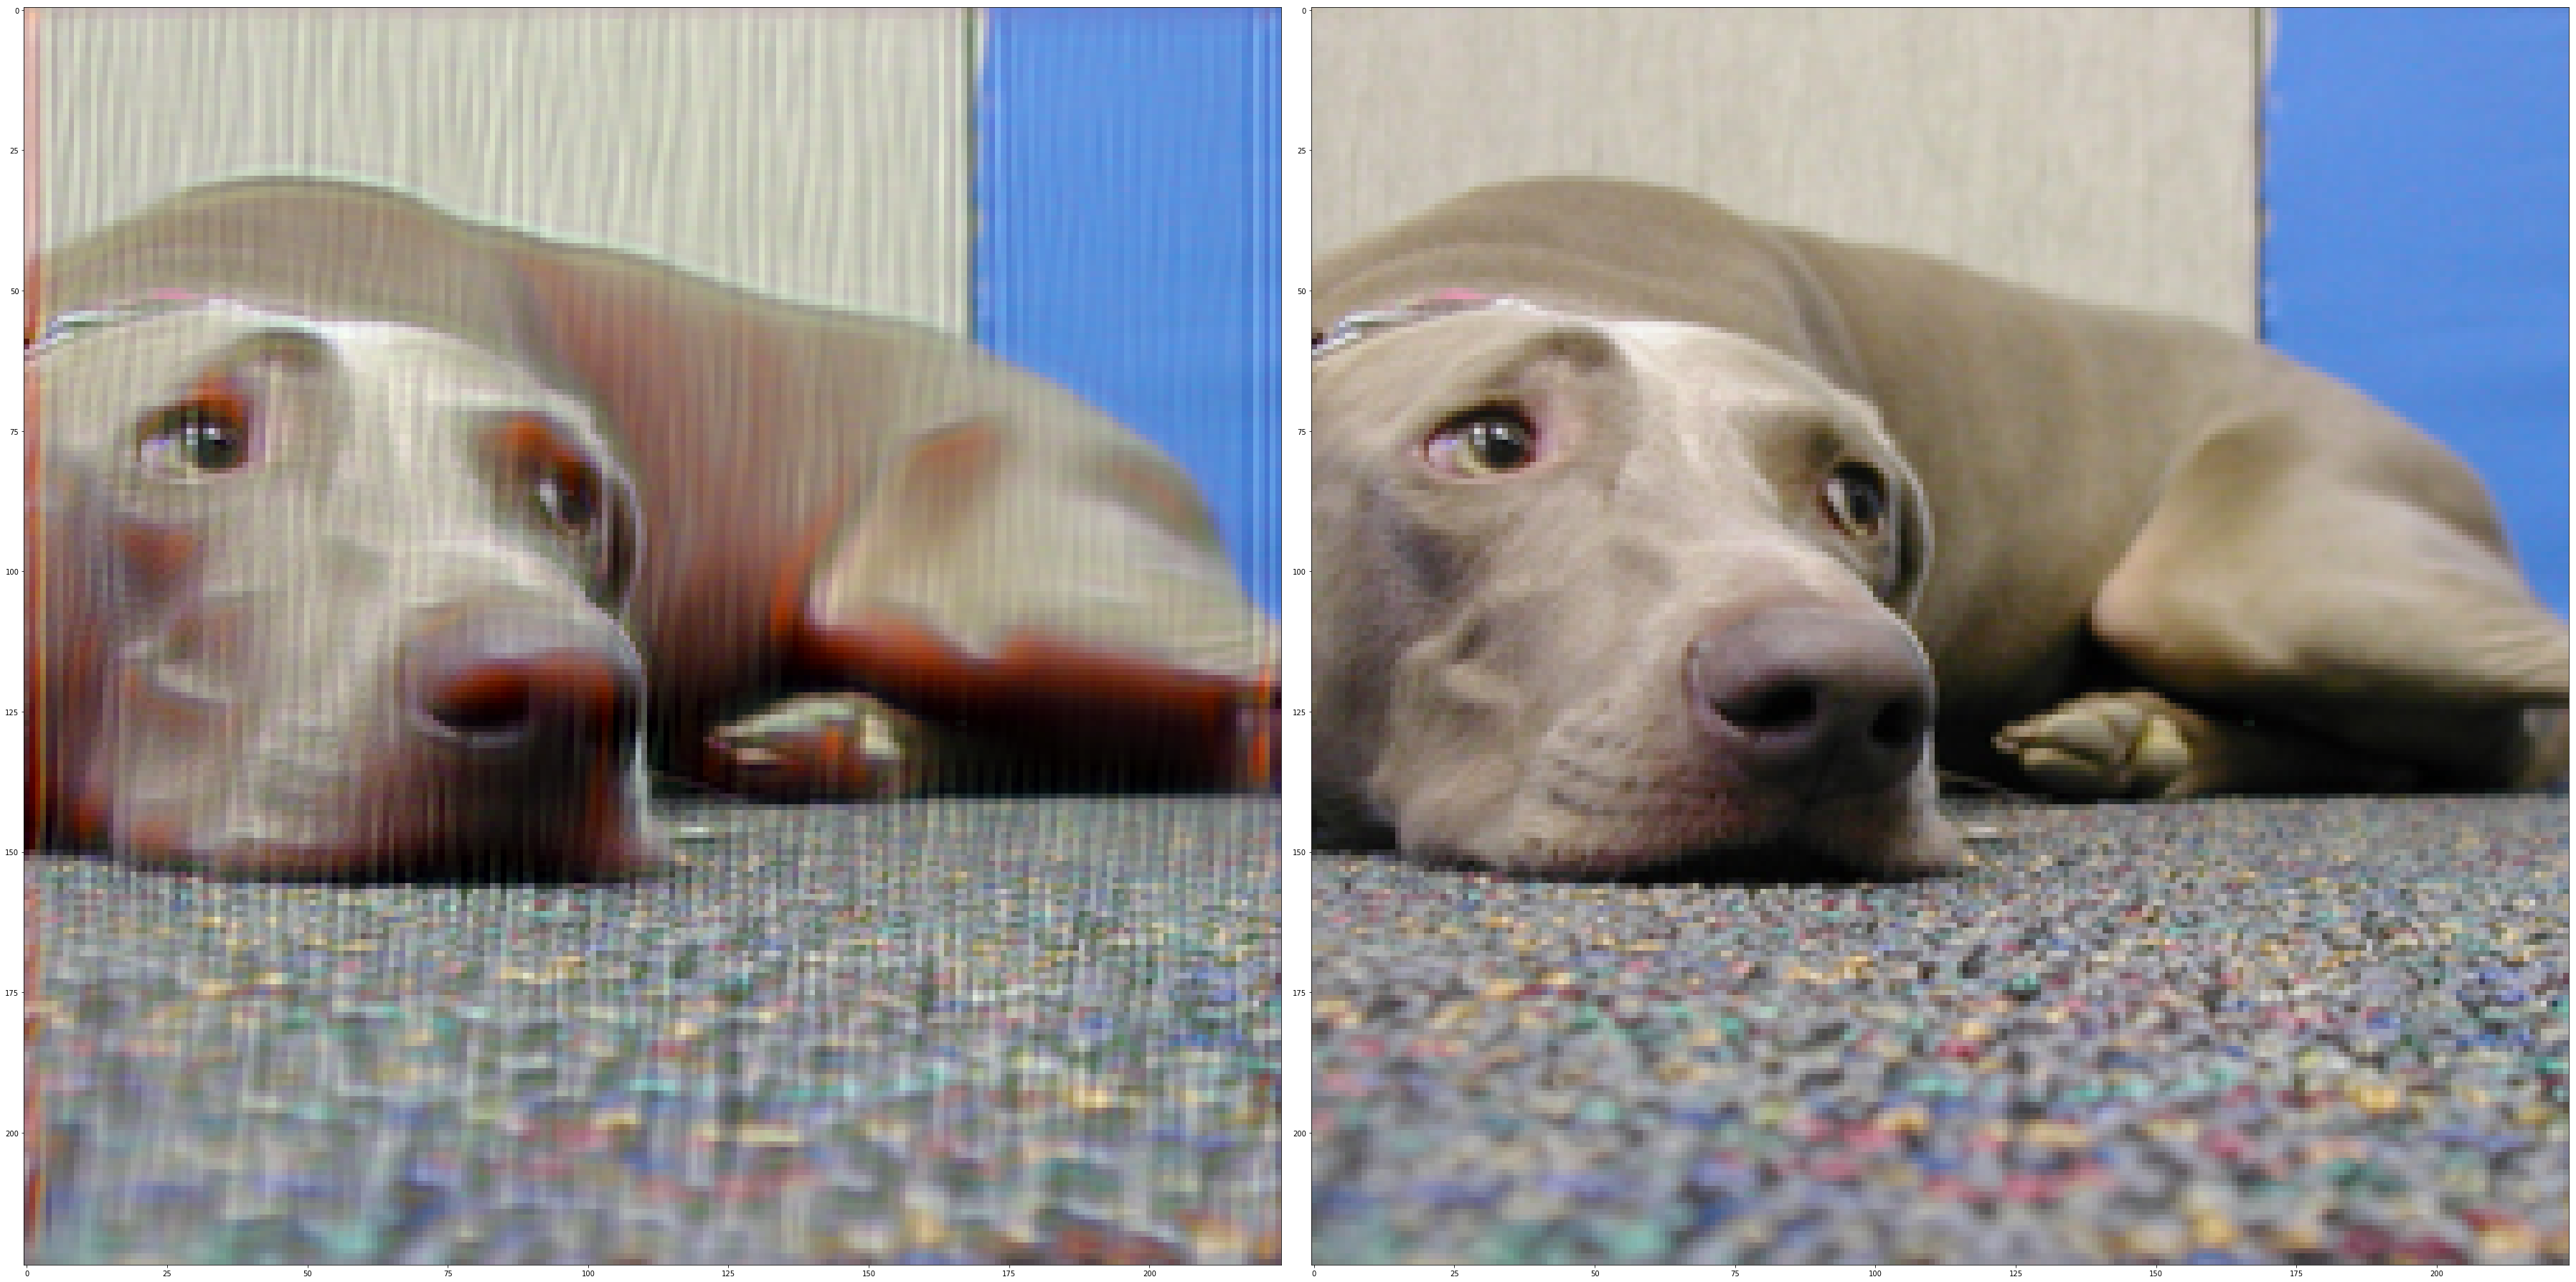

In [4]:
advnet = ParallelResNet(
    epsilon=0.5, 
    advnet_norm_factor=0.1
)

MODEL_PATH = "/accounts/projects/jsteinhardt/sauravkadavath/imagenet-classifier/checkpoints/advnetOnly_train_100/model.pth.tar"
advnet.load_state_dict(torch.load(MODEL_PATH)['advnet_state_dict'])
advnet.cpu()
print("Loaded advnet")

def show_image(img, plt):
    img = img.permute((1,2,0))
    npimg = np.asarray(img)
    print(npimg.shape)
    plt.imshow(npimg, interpolation='nearest')

with torch.no_grad():
    advnet.eval()
    for i, (images, target) in enumerate(val_loader):
        # measure data loading time

        bx = images.cuda(non_blocking=True)
        by = target.cuda(non_blocking=True)

        bx_copy = bx.clone().detach().cpu()

        # Random class target for advnet
        rand_class = 87
        advnet.blocks[rand_class].cuda()

        res = advnet(bx, road=rand_class)
        advnet_out = res["output"] 
        advnet_out_copy = advnet_out.clone().detach().cpu()

        # Save GPU memory
        advnet.blocks[rand_class].cpu()

        fig, ax = plt.subplots(1, 2)
        fig.set_size_inches(50, 50)
        fig.tight_layout()

        print(classes_chosen[rand_class])
        show_image(unnorm_fn(advnet_out_copy[0]).detach(), ax[0])
        show_image(unnorm_fn(bx_copy[0]).detach(), ax[1])

        break
    
del advnet
torch.cuda.empty_cache()